In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, classification_report , roc_curve, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.utils import resample 
from sklearn.naive_bayes import GaussianNB

In [2]:
# set matplotlib defaults
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (15,6)
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rc('figure', titlesize=18)
plt.style.use('seaborn-darkgrid')

In [3]:
data = pd.read_csv("../data/dataset_2019_with_negatives.csv")

In [4]:
data = data.drop(columns=['year', 'precipAccumulation'])

In [5]:
data.head()

,x,y,timestamp,date,month,day,day_of_year,day_of_week,hour,address,...,humidity,windSpeed,cloudCover,uvIndex,visibility,windBearing,windGust,pressure,precipType,ozone
0,-74.134363,4.579297,2019-01-11 14:20:00,2019-01-11,1,11,11,4,14,KR 26-CL 52B S 2,...,0.93,1.66,0.89,4.0,13.489,167.0,1.66,1018.0,rain,239.8
1,-74.048819,4.665144,2019-01-11 11:30:00,2019-01-11,1,11,11,4,11,CL 84-KR 8 2,...,0.97,1.11,0.83,0.0,12.254,128.0,1.15,1017.2,rain,240.5
2,-74.173301,4.615589,2019-01-11 23:20:00,2019-01-11,1,11,11,4,23,KR 80-CL 53A S 2,...,0.95,1.65,0.81,0.0,6.814,10.0,2.07,1014.8,rain,237.9
3,-74.025068,4.725288,2019-01-11 06:30:00,2019-01-11,1,11,11,4,6,KR 7-CL 150 2,...,0.88,0.97,0.90,0.0,15.389,41.0,0.99,1017.1,rain,242.7
4,-74.044628,4.752517,2019-01-11 06:00:00,2019-01-11 00:00:00,1,11,11,4,6,CL 172-KR 22A 2,...,0.88,0.97,0.90,0.0,15.389,41.0,0.99,1017.1,rain,242.7


In [6]:
data = pd.get_dummies(data, columns=['summary', 'borough'])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58133 entries, 0 to 58132
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   x                            58133 non-null  float64
 1   y                            58133 non-null  float64
 2   timestamp                    58133 non-null  object 
 3   date                         58133 non-null  object 
 4   month                        58133 non-null  int64  
 5   day                          58133 non-null  int64  
 6   day_of_year                  58133 non-null  int64  
 7   day_of_week                  58133 non-null  int64  
 8   hour                         58133 non-null  int64  
 9   address                      58133 non-null  object 
 10  severity                     29067 non-null  object 
 11  accident_type                29067 non-null  object 
 12  severity_numeric             29067 non-null  float64
 13  cluster_id      

In [8]:
corr = data.corr()
c1 = corr.abs().unstack().round(3)
c1<1
c1[(c1<1) & (c1> 0.65)].sort_values(ascending = False)

apparentTemperature          temperature                    0.998
temperature                  apparentTemperature            0.998
month                        day_of_year                    0.996
day_of_year                  month                          0.996
temperature                  uvIndex                        0.833
uvIndex                      temperature                    0.833
windSpeed                    windGust                       0.826
windGust                     windSpeed                      0.826
uvIndex                      apparentTemperature            0.824
apparentTemperature          uvIndex                        0.824
precipProbability            precipIntensity                0.783
precipIntensity              precipProbability              0.783
temperature                  hour                           0.694
hour                         temperature                    0.694
apparentTemperature          hour                           0.688
hour      

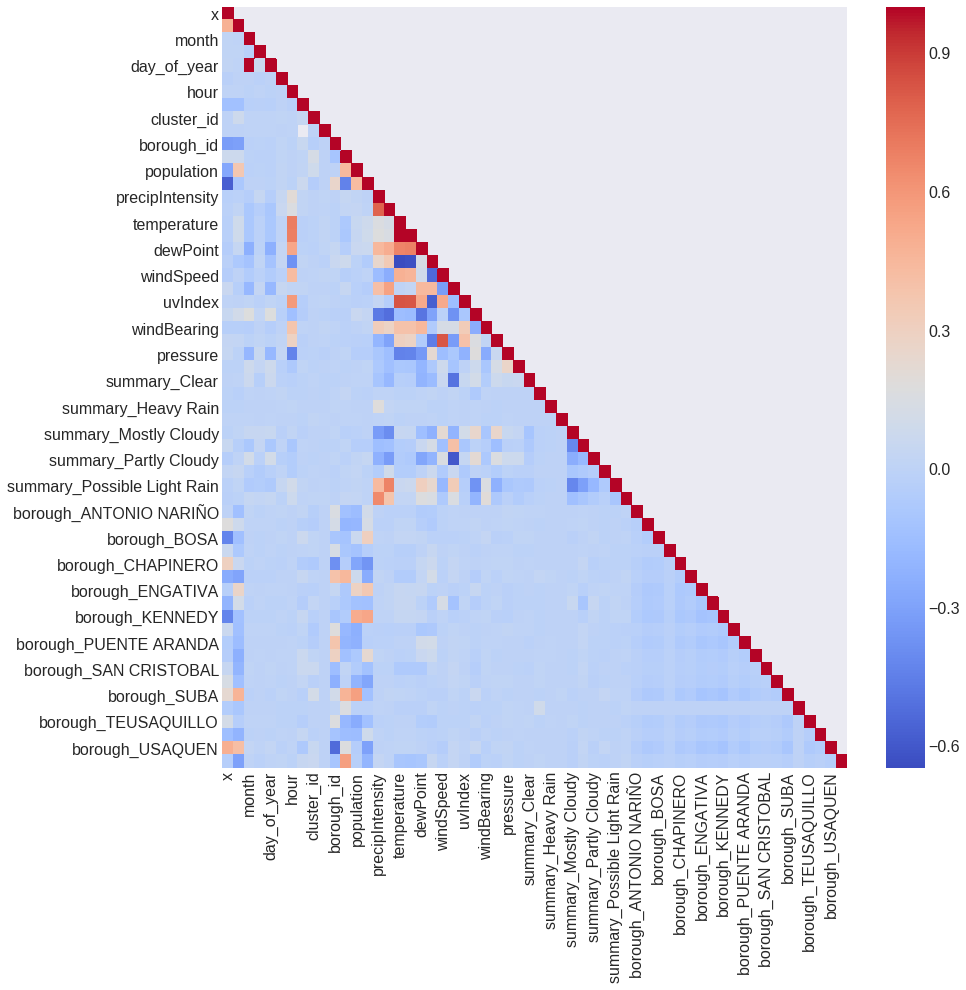

In [10]:
plt.figure(figsize=(14,14))
sns.heatmap(corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)), cmap='coolwarm')
plt.show()

## Useful Functions

In [11]:
def get_df(columns):
    return data[columns]

In [12]:
def separate_classes(df):
    return df[df.sample_type==0], df[df.sample_type==1]

In [13]:
def resample_df(resample_type, df_majority, df_minority):
    if resample_type == 'up':
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, replace=True, n_samples=df_majority.shape[0])        
        # Combine majority class with upsampled minority class
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])
        
        return df_upsampled

    if resample_type == 'down':
        # Upsample minority class
        df_majority_undersampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0])        
        # Combine majority class with upsampled minority class
        df_undersampled = pd.concat([df_minority, df_majority_undersampled])
        
        return df_undersampled 

In [14]:
def train_test_df(df, columns):
    cols = columns
    cols.remove('sample_type')
    X = df[columns]
    y = df.sample_type
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    return X_train, X_test, y_train, y_test  

In [15]:
def model_fit_predict(X_train, X_test, y_train, y_test):
    categories = ['non-accident', 'accident']
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring= 'f1_weighted', n_jobs=-1)
    print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

    y_pred = clf.predict(X_test)
    print('Cohen kappa score {:.4f}'.format(cohen_kappa_score(y_pred, y_test)))
    print(classification_report(y_test, y_pred,target_names=categories))

    metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
    scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
    cv = KFold(n_splits=10)
    scv = StratifiedKFold(n_splits=10)
    for metric in metric_names:
        score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
        score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
        scores_df.loc[metric] = [score1, score2]
    print(scores_df)
    y_pred_proba = clf.predict_proba(X_test)[:,1]

    return clf, y_pred, y_pred_proba


In [16]:
def model_plot(y_test, y_pred, y_pred_proba, model_name):
    categories = ['non-accident', 'accident']
    gs = mpl.gridspec.GridSpec(2, 2)

    plt.figure(figsize=(14,10))
    ax = plt.subplot(gs[0, 0]) # row 0, col 0
    labels = [0,1]
    cnf_mx = confusion_matrix(y_test,y_pred,labels=labels)
    ax1 = sns.heatmap(cnf_mx, cmap='coolwarm',annot=True, fmt="d")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Confusion matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    ax = plt.subplot(gs[0, 1]) # row 0, col 1
    row_sums = cnf_mx.sum(axis=1, keepdims=True)
    norm_cnf_mx = cnf_mx / row_sums
    np.fill_diagonal(norm_cnf_mx, 0)
    ax2 = sns.heatmap(norm_cnf_mx, cmap='coolwarm',annot=True, fmt=".4%")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Error matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')

    ax = plt.subplot(gs[1, :]) # row 1, span all columns
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    # Display plot for AUC curve
    ax3 = plt.plot(fpr,tpr,label= f"{model_name}, auc={round(auc,4)}")
    ax3 = plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.legend(fontsize=14)
    plt.title(f"ROC cuve: {model_name}", fontsize= 18)
    plt.tight_layout()
    plt.show()

In [17]:
def generate_cyclical_variables(df, column, period):
    if df[column].min() != 0:
        df[f'{column}_sin'] = np.sin((df[column] - 1)*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column] - 1)*(2.*np.pi/period))
    else:
        df[f'{column}_sin'] = np.sin((df[column])*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column])*(2.*np.pi/period))

    return df

In [18]:
generate_cyclical_variables(data, 'hour', 24)
generate_cyclical_variables(data, 'day_of_week', 7)
generate_cyclical_variables(data, 'month', 12)
generate_cyclical_variables(data, 'day_of_year', 365)

,x,y,timestamp,date,month,day,day_of_year,day_of_week,hour,address,...,borough_USAQUEN,borough_USME,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,-74.134363,4.579297,2019-01-11 14:20:00,2019-01-11,1,11,11,4,14,KR 26-CL 52B S 2,...,0,0,-0.500000,-8.660254e-01,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
1,-74.048819,4.665144,2019-01-11 11:30:00,2019-01-11,1,11,11,4,11,CL 84-KR 8 2,...,0,0,0.258819,-9.659258e-01,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
2,-74.173301,4.615589,2019-01-11 23:20:00,2019-01-11,1,11,11,4,23,KR 80-CL 53A S 2,...,0,0,-0.258819,9.659258e-01,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
3,-74.025068,4.725288,2019-01-11 06:30:00,2019-01-11,1,11,11,4,6,KR 7-CL 150 2,...,1,0,1.000000,6.123234e-17,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
4,-74.044628,4.752517,2019-01-11 06:00:00,2019-01-11 00:00:00,1,11,11,4,6,CL 172-KR 22A 2,...,1,0,1.000000,6.123234e-17,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58128,-74.135687,4.580801,2019-12-03 16:00:00,2019-12-03 00:00:00,12,3,337,1,16,KR 28-DG 52B S 2,...,0,0,-0.866025,-5.000000e-01,0.781831,0.623490,-0.5,8.660254e-01,-0.478734,0.877960
58129,-74.084275,4.590371,2019-01-12 04:00:00,2019-01-12 00:00:00,1,12,12,5,4,KR 10-CL 1B 02,...,0,0,0.866025,5.000000e-01,-0.974928,-0.222521,0.0,1.000000e+00,0.188227,0.982126
58130,-74.097752,4.619585,2019-10-04 16:00:00,2019-10-04 00:00:00,10,4,277,4,16,CL 13-KR 37 35,...,0,0,-0.866025,-5.000000e-01,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.999250,0.038722
58131,-74.174217,4.576242,2019-12-20 19:00:00,2019-12-20 00:00:00,12,20,354,4,19,KR 75-CL 75D S 02,...,0,0,-0.965926,2.588190e-01,-0.433884,-0.900969,-0.5,8.660254e-01,-0.205104,0.978740


## Model 0

### All numeric variables

In [19]:
data.columns

Index(['x', 'y', 'timestamp', 'date', 'month', 'day', 'day_of_year',
       'day_of_week', 'hour', 'address', 'severity', 'accident_type',
       'severity_numeric', 'cluster_id', 'sample_type', 'borough_id',
       'area_km2', 'population', 'population_density', 'timestamp_darksky',
       'icon', 'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility', 'windBearing', 'windGust',
       'pressure', 'precipType', 'ozone', 'summary_Clear', 'summary_Foggy',
       'summary_Heavy Rain', 'summary_Light Rain', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain', 'borough_ANTONIO NARIÑO',
       'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
       'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
       'borough_FONTIBON', 'borough_KENNEDY', 'b

In [20]:
feature_columns_model_0 = ['x', 'y',
       'area_km2', 'population', 'population_density', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'pressure', 'ozone',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos','sample_type']

In [21]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_df(data, feature_columns_model_0)

In [22]:
clf0, y_pred_0, y_pred_proba_0 = model_fit_predict(X_train_0, X_test_0, y_train_0, y_test_0)

Weigthed F1 score: 0.49 (+/- 0.035 )
Cohen kappa score 0.0167
              precision    recall  f1-score   support

non-accident       0.50      0.70      0.58      9507
    accident       0.52      0.32      0.39      9677

    accuracy                           0.51     19184
   macro avg       0.51      0.51      0.49     19184
weighted avg       0.51      0.51      0.49     19184

                  Random-CV Stratified-CV
f1                 0.394295      0.393638
roc_auc            0.509026      0.508738
average_precision  0.504527      0.504409
accuracy           0.505815      0.505276
precision          0.505617      0.504192
recall             0.329692      0.329551


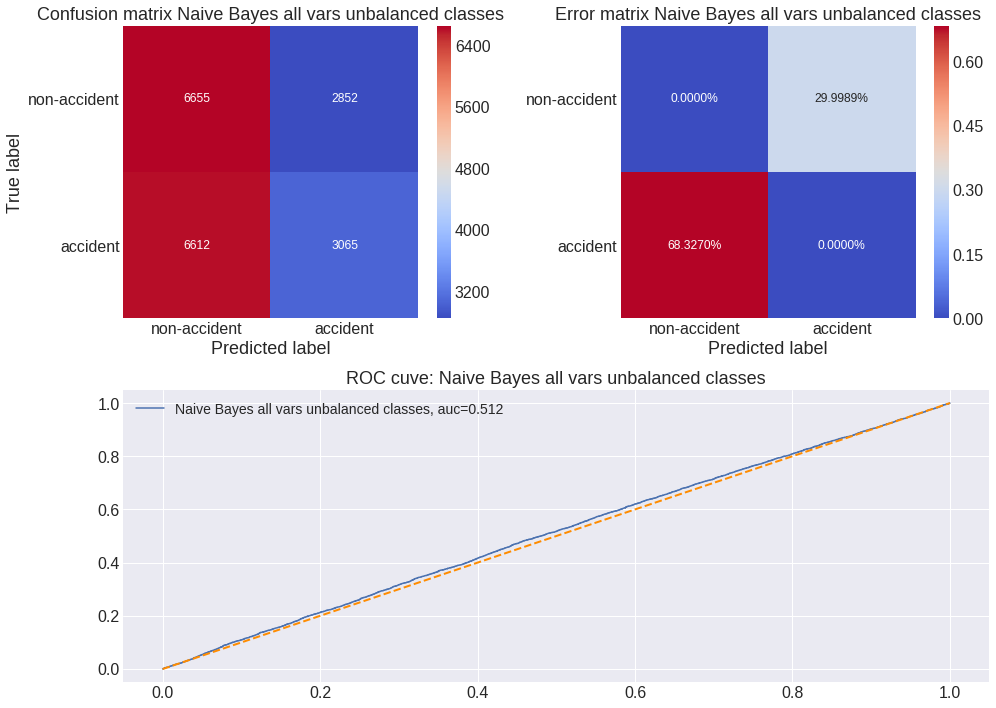

In [23]:
model_plot(y_test_0, y_pred_0, y_pred_proba_0, 'Naive Bayes all vars unbalanced classes')

## First model

###  All variables numeric + categorical (summary and borough)

In [24]:
data.columns

Index(['x', 'y', 'timestamp', 'date', 'month', 'day', 'day_of_year',
       'day_of_week', 'hour', 'address', 'severity', 'accident_type',
       'severity_numeric', 'cluster_id', 'sample_type', 'borough_id',
       'area_km2', 'population', 'population_density', 'timestamp_darksky',
       'icon', 'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility', 'windBearing', 'windGust',
       'pressure', 'precipType', 'ozone', 'summary_Clear', 'summary_Foggy',
       'summary_Heavy Rain', 'summary_Light Rain', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain', 'borough_ANTONIO NARIÑO',
       'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
       'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
       'borough_FONTIBON', 'borough_KENNEDY', 'b

In [26]:
feature_columns_model_1 = ['x', 'y', 'population_density', 'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility', 'windBearing', 'windGust',
       'pressure', 'ozone', 'summary_Clear', 'summary_Foggy',
       'summary_Heavy Rain', 'summary_Light Rain', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain', 'borough_ANTONIO NARIÑO',
       'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
       'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
       'borough_FONTIBON', 'borough_KENNEDY', 'borough_LOS MARTIRES',
       'borough_PUENTE ARANDA', 'borough_RAFAEL URIBE URIBE',
       'borough_SAN CRISTOBAL', 'borough_SANTA FE', 'borough_SUBA',
       'borough_SUMAPAZ', 'borough_TEUSAQUILLO', 'borough_TUNJUELITO',
       'borough_USAQUEN', 'borough_USME', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos','sample_type']

In [27]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_df(data, feature_columns_model_1)

In [28]:
clf1, y_pred_1, y_pred_proba_1 = model_fit_predict(X_train_1, X_test_1, y_train_1, y_test_1 )

Weigthed F1 score: 0.51 (+/- 0.018 )
Cohen kappa score 0.0082
              precision    recall  f1-score   support

non-accident       0.50      0.59      0.54      9576
    accident       0.51      0.42      0.46      9608

    accuracy                           0.50     19184
   macro avg       0.50      0.50      0.50     19184
weighted avg       0.50      0.50      0.50     19184

                  Random-CV Stratified-CV
f1                 0.462428      0.462901
roc_auc            0.510377      0.510293
average_precision  0.509857      0.509712
accuracy           0.509923      0.510308
precision          0.511779      0.512107
recall             0.422436      0.422889


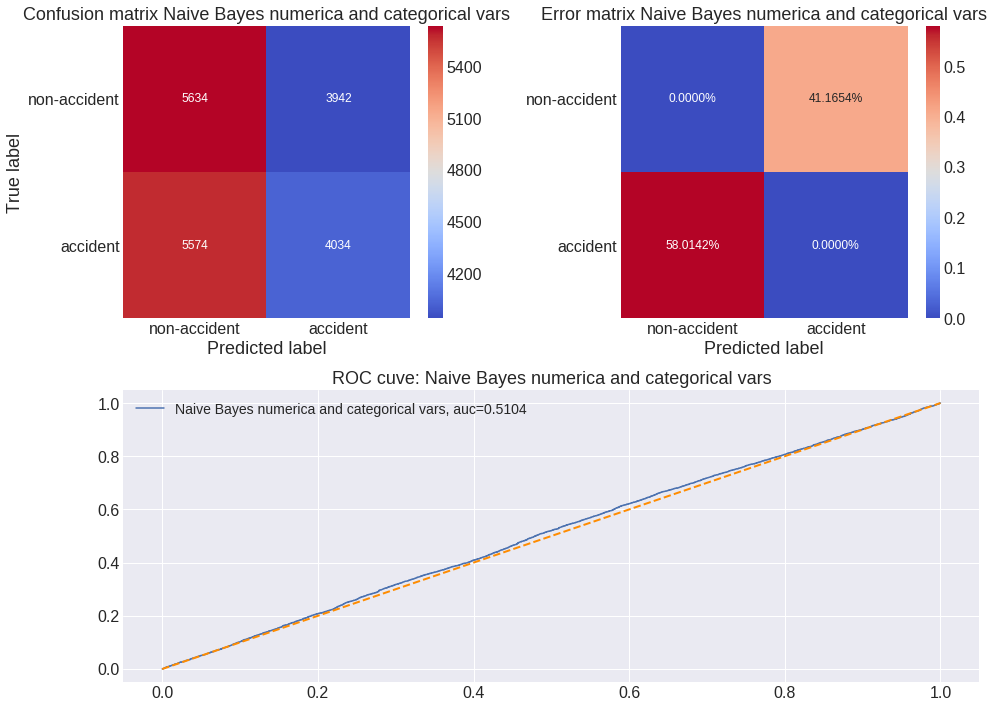

In [29]:
model_plot(y_test_1, y_pred_1, y_pred_proba_1, 'Naive Bayes numerica and categorical vars')

###  All variables numeric + categorical summary

In [33]:
feature_columns_model_11 = ['x', 'y', 'population_density', 'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility', 'windBearing', 'windGust',
       'pressure', 'ozone', 'summary_Clear', 'summary_Foggy',
       'summary_Heavy Rain', 'summary_Light Rain', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos', 'sample_type']

In [34]:
X_train_11, X_test_11, y_train_11, y_test_11 = train_test_df(data, feature_columns_model_11)
clf11, y_pred_11, y_pred_proba_11 = model_fit_predict(X_train_11, X_test_11, y_train_11, y_test_11)

Weigthed F1 score: 0.51 (+/- 0.014 )
Cohen kappa score 0.0199
              precision    recall  f1-score   support

non-accident       0.51      0.55      0.53      9543
    accident       0.51      0.47      0.49      9641

    accuracy                           0.51     19184
   macro avg       0.51      0.51      0.51     19184
weighted avg       0.51      0.51      0.51     19184

                  Random-CV Stratified-CV
f1                  0.49082      0.490709
roc_auc            0.513352      0.513066
average_precision  0.509697      0.509485
accuracy           0.512183      0.511977
precision          0.512078      0.511586
recall             0.471905      0.471845


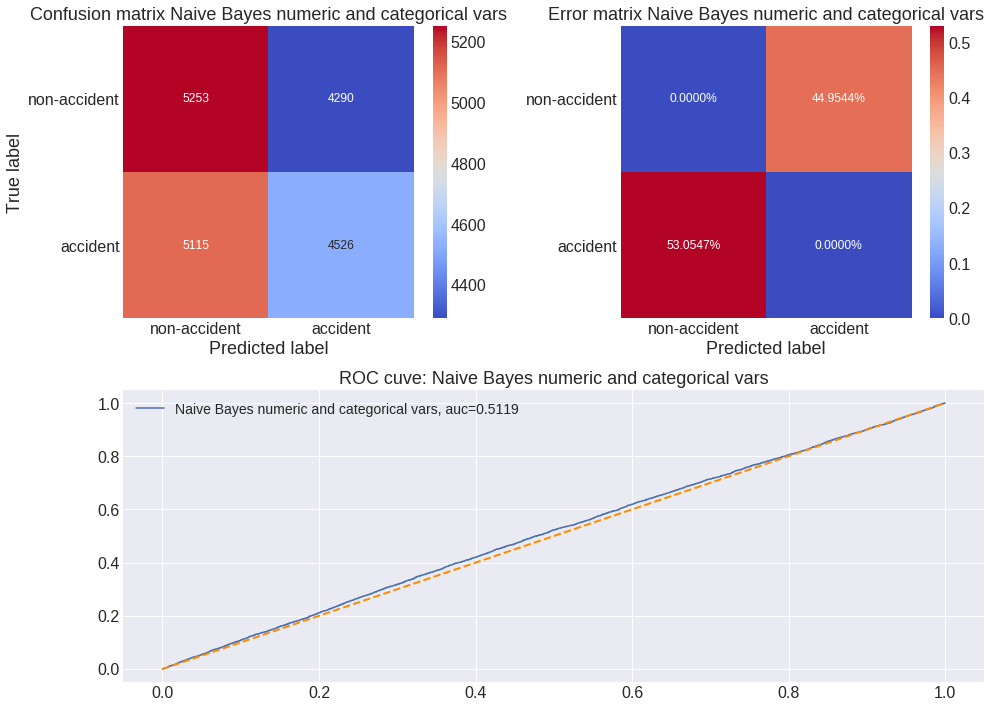

In [36]:
model_plot(y_test_11, y_pred_11, y_pred_proba_11, 'Naive Bayes numeric and categorical vars')

## Second model

###  Numeric weather Covariates

In [37]:
data.columns 

Index(['x', 'y', 'timestamp', 'date', 'month', 'day', 'day_of_year',
       'day_of_week', 'hour', 'address', 'severity', 'accident_type',
       'severity_numeric', 'cluster_id', 'sample_type', 'borough_id',
       'area_km2', 'population', 'population_density', 'timestamp_darksky',
       'icon', 'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility', 'windBearing', 'windGust',
       'pressure', 'precipType', 'ozone', 'summary_Clear', 'summary_Foggy',
       'summary_Heavy Rain', 'summary_Light Rain', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain', 'borough_ANTONIO NARIÑO',
       'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
       'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
       'borough_FONTIBON', 'borough_KENNEDY', 'b

In [50]:
columns_model_2 = ['x', 'y', 'population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'dewPoint', 'humidity','windSpeed', 
       'cloudCover', 'visibility', 'pressure', 'borough_ANTONIO NARIÑO',
       'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
       'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
       'borough_FONTIBON', 'borough_KENNEDY', 'borough_LOS MARTIRES',
       'borough_PUENTE ARANDA', 'borough_RAFAEL URIBE URIBE',
       'borough_SAN CRISTOBAL', 'borough_SANTA FE', 'borough_SUBA',
       'borough_SUMAPAZ', 'borough_TEUSAQUILLO', 'borough_TUNJUELITO',
       'borough_USAQUEN', 'borough_USME', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos', 'sample_type']

In [51]:
feature_selecition_df = get_df(columns_model_2)

In [52]:
feature_selecition_df['precipitation_probability_intesity'] = feature_selecition_df['precipIntensity'] * feature_selecition_df['precipProbability']

In [53]:
feature_selecition_df = feature_selecition_df.drop(columns=['precipIntensity', 'precipProbability'])

In [54]:
columns_model_20 = ['x', 'y', 'population_density', 'precipitation_probability_intesity',
       'temperature', 'dewPoint', 'humidity','windSpeed', 
       'cloudCover', 'visibility', 'pressure', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos', 'sample_type']

In [55]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_df(feature_selecition_df, columns_model_20)
clf2, y_pred_2, y_pred_proba_2 = model_fit_predict(X_train_2, X_test_2, y_train_2, y_test_2)

Weigthed F1 score: 0.51 (+/- 0.014 )
Cohen kappa score 0.0198
              precision    recall  f1-score   support

non-accident       0.51      0.58      0.54      9591
    accident       0.51      0.44      0.47      9593

    accuracy                           0.51     19184
   macro avg       0.51      0.51      0.51     19184
weighted avg       0.51      0.51      0.51     19184

                  Random-CV Stratified-CV
f1                 0.471045       0.47029
roc_auc            0.511467      0.511423
average_precision  0.509902      0.509784
accuracy            0.50941      0.508974
precision           0.51109      0.510562
recall             0.437142       0.43612


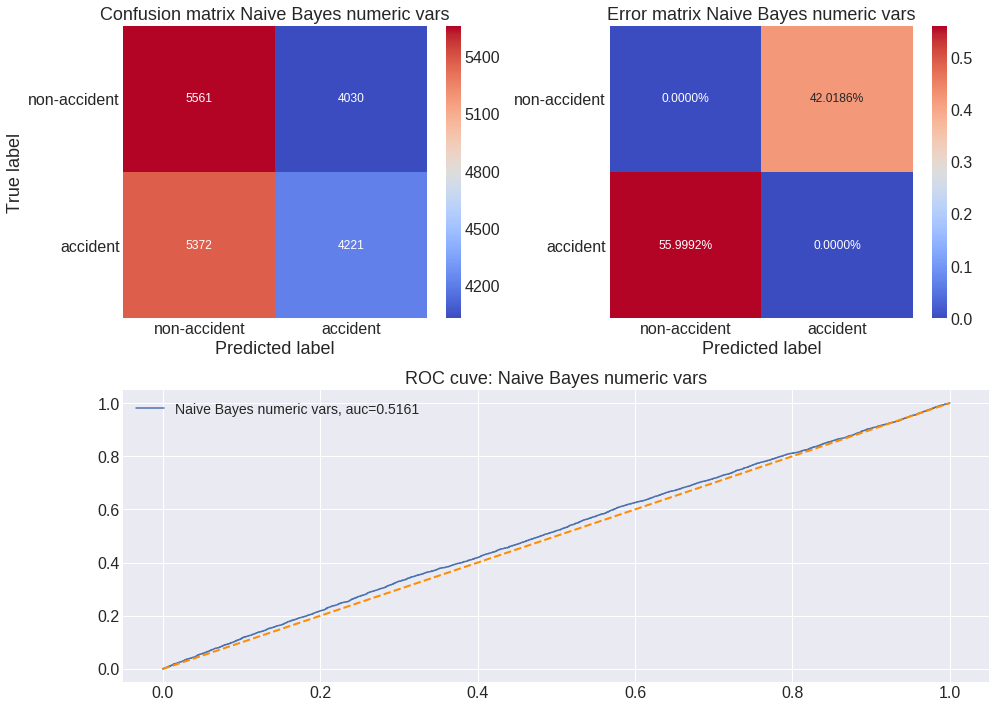

In [56]:
model_plot(y_test_2, y_pred_2, y_pred_proba_2, 'Naive Bayes numeric vars')

In [58]:
columns_model_21 = ['x', 'y', 'population_density',
       'temperature', 'dewPoint', 'humidity','windSpeed', 
       'cloudCover', 'visibility', 'pressure', 'borough_ANTONIO NARIÑO',
       'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
       'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
       'borough_FONTIBON', 'borough_KENNEDY', 'borough_LOS MARTIRES',
       'borough_PUENTE ARANDA', 'borough_RAFAEL URIBE URIBE',
       'borough_SAN CRISTOBAL', 'borough_SANTA FE', 'borough_SUBA',
       'borough_SUMAPAZ', 'borough_TEUSAQUILLO', 'borough_TUNJUELITO',
       'borough_USAQUEN', 'borough_USME', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos', 'sample_type']

In [59]:
X_train_21, X_test_21, y_train_21, y_test_21 = train_test_df(feature_selecition_df, columns_model_21)
clf21, y_pred_21, y_pred_proba_21 = model_fit_predict(X_train_21, X_test_21, y_train_21, y_test_21)

Weigthed F1 score: 0.51 (+/- 0.012 )
Cohen kappa score 0.0127
              precision    recall  f1-score   support

non-accident       0.51      0.57      0.54      9601
    accident       0.51      0.44      0.47      9583

    accuracy                           0.51     19184
   macro avg       0.51      0.51      0.50     19184
weighted avg       0.51      0.51      0.50     19184

                  Random-CV Stratified-CV
f1                 0.476786      0.476872
roc_auc            0.507917      0.507963
average_precision   0.50904      0.509079
accuracy           0.510642      0.510616
precision          0.512631      0.512553
recall             0.445892      0.445956


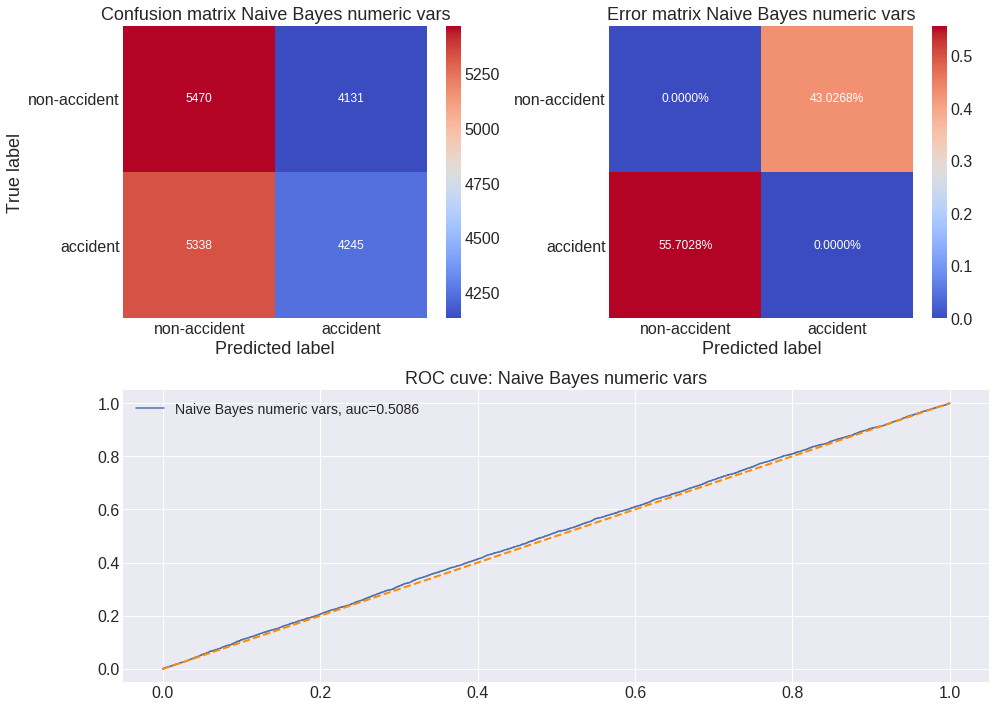

In [60]:
model_plot(y_test_21, y_pred_21, y_pred_proba_21, 'Naive Bayes numeric vars')

## Model 3

### Categorical weather variables

In [61]:
data.columns 

Index(['x', 'y', 'timestamp', 'date', 'month', 'day', 'day_of_year',
       'day_of_week', 'hour', 'address', 'severity', 'accident_type',
       'severity_numeric', 'cluster_id', 'sample_type', 'borough_id',
       'area_km2', 'population', 'population_density', 'timestamp_darksky',
       'icon', 'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility', 'windBearing', 'windGust',
       'pressure', 'precipType', 'ozone', 'summary_Clear', 'summary_Foggy',
       'summary_Heavy Rain', 'summary_Light Rain', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain', 'borough_ANTONIO NARIÑO',
       'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
       'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
       'borough_FONTIBON', 'borough_KENNEDY', 'b

In [62]:
columns_model_3 = ['x', 'y', 'population_density', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos','sample_type']

In [63]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_df(data, columns_model_3)
clf3, y_pred_3, y_pred_proba_3 = model_fit_predict(X_train_3, X_test_3, y_train_3, y_test_3)

Weigthed F1 score: 0.49 (+/- 0.015 )
Cohen kappa score 0.0102
              precision    recall  f1-score   support

non-accident       0.51      0.37      0.43      9626
    accident       0.50      0.64      0.56      9558

    accuracy                           0.50     19184
   macro avg       0.51      0.51      0.50     19184
weighted avg       0.51      0.50      0.50     19184

                  Random-CV Stratified-CV
f1                 0.557504      0.560136
roc_auc            0.500724      0.500638
average_precision  0.502719      0.502768
accuracy           0.499705      0.501014
precision          0.500924      0.501336
recall             0.633762      0.636372


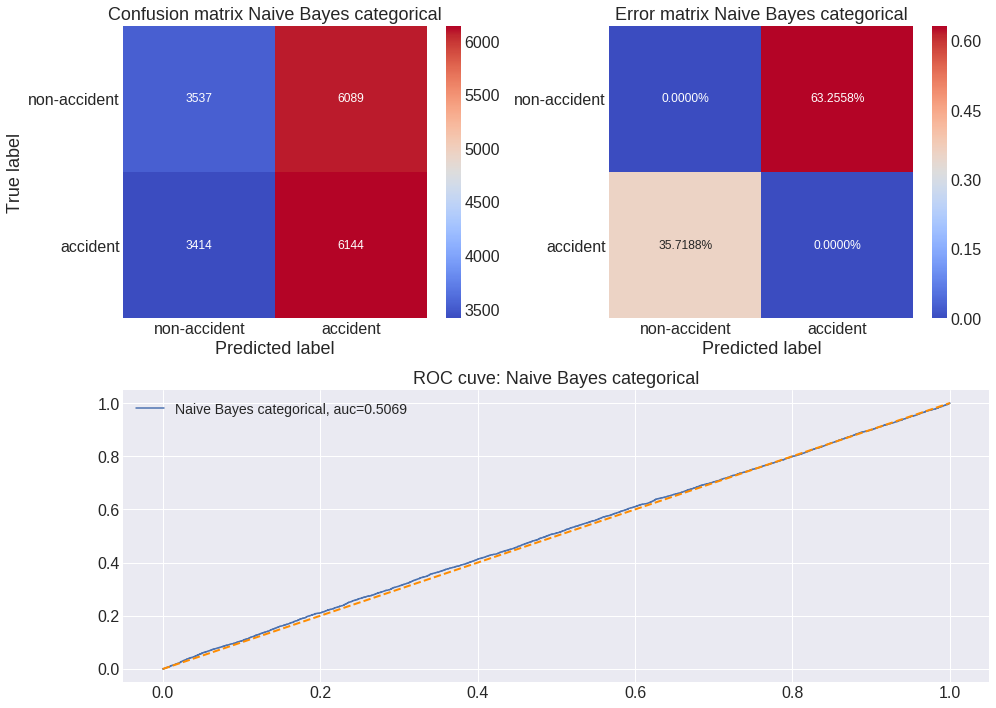

In [64]:
model_plot(y_test_3, y_pred_3, y_pred_proba_3, 'Naive Bayes categorical')

In [65]:
columns_model_31 = ['x', 'y', 'population_density', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos', 'borough_ANTONIO NARIÑO',
       'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
       'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
       'borough_FONTIBON', 'borough_KENNEDY', 'borough_LOS MARTIRES',
       'borough_PUENTE ARANDA', 'borough_RAFAEL URIBE URIBE',
       'borough_SAN CRISTOBAL', 'borough_SANTA FE', 'borough_SUBA',
       'borough_SUMAPAZ', 'borough_TEUSAQUILLO', 'borough_TUNJUELITO',
       'borough_USAQUEN', 'borough_USME','sample_type']


In [66]:
X_train_31, X_test_31, y_train_31, y_test_31 = train_test_df(data, columns_model_31)
clf31, y_pred_31, y_pred_proba_31 = model_fit_predict(X_train_31, X_test_31, y_train_31, y_test_31)

Weigthed F1 score: 0.50 (+/- 0.009 )
Cohen kappa score -0.0085
              precision    recall  f1-score   support

non-accident       0.49      0.49      0.49      9560
    accident       0.50      0.50      0.50      9624

    accuracy                           0.50     19184
   macro avg       0.50      0.50      0.50     19184
weighted avg       0.50      0.50      0.50     19184

                  Random-CV Stratified-CV
f1                  0.49273      0.495067
roc_auc            0.498779      0.498903
average_precision  0.501341      0.501529
accuracy           0.496829      0.497882
precision          0.495958      0.496956
recall              0.49006      0.494008


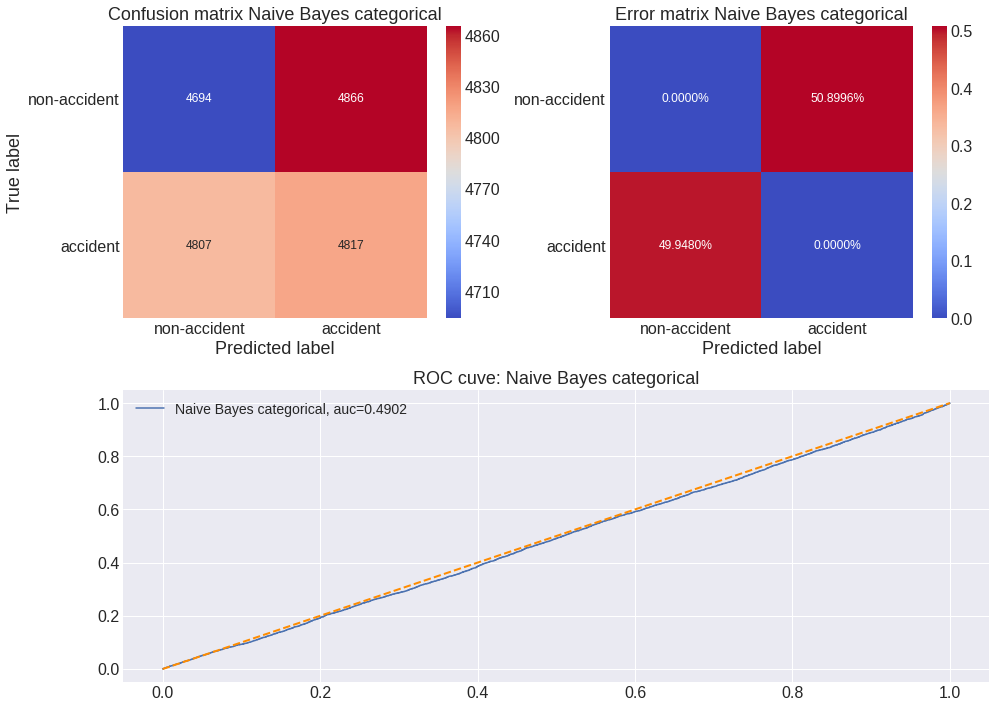

In [67]:
model_plot(y_test_31, y_pred_31, y_pred_proba_31, 'Naive Bayes categorical')